In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline

In [60]:
train_df = pd.read_csv("data/dui.csv")
test_df = pd.read_csv("data/dui-test.csv")

In [78]:
train_df.head()

,Age,Gender,BAC,speeding5MPH,speeding10MPH,Fatality
0,56,1,0.017,0,0,0
1,38,1,0.034,0,0,1
2,22,0,0.000,1,0,0
3,71,0,0.046,1,1,0
4,63,0,0.000,0,0,0


# Cleaning the dataset
* Gender column can be encoded into 0 for "Female" and 1 for "Male". 
* Since the goal is to classify whether there was a fatality or not, we convert all fatal incidents to 1 and no fatalities to 0

In [75]:
def clean_data(df, train=False):  
    df.loc[df['Gender'] == 'M', 'Gender'] = 1
    df.loc[df['Gender'] == 'F', 'Gender'] = 0
    
    if train:
        df.loc[df['Fatality'] > 0, 'Fatality'] = 1
        df.loc[df['Fatality'] <= 0, 'Fatality'] = 0

In [63]:
clean_data(train_df, True)
clean_data(test_df, False)

In [64]:
columns = ["Age", "Gender", "BAC", "speeding5MPH", "speeding10MPH"]
y_columns = ["Fatality"]
train_X = train_df[columns]
train_Y = train_df["Fatality"]
test_X = test_df[columns]

# Selecting Features
To select which of the features from Age, Gender, BAC, speeding5MPH and speeding10MPH has resulted in fatalic incidents, we explore the distributions of each feature to fatality

## Total fatalities

2690 of 8319 incidents were fatal and it is the 32.34% of the training set.
5629 of 8319 incidents were not fatal and it is the 67.66% of the training set.


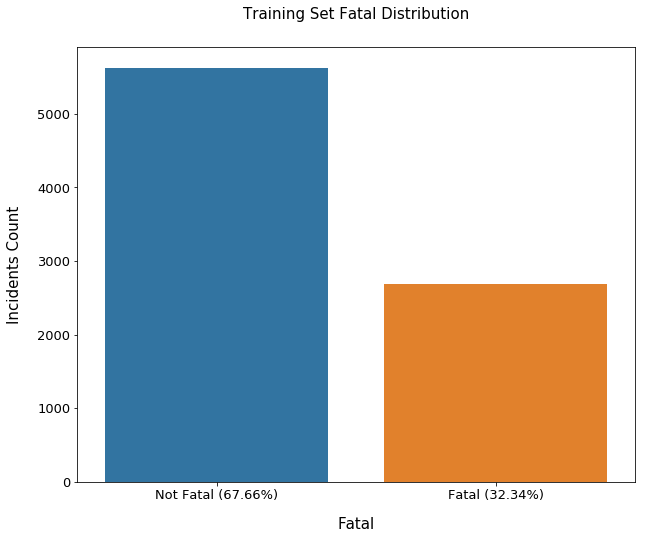

In [65]:
fatalic = train_df['Fatality'].value_counts()[1]
not_fatalic = train_df['Fatality'].value_counts()[0]
fatal_percentage = fatalic / train_df.shape[0] * 100
not_fatal_percentage = not_fatalic / train_df.shape[0] * 100

print('{} of {} incidents were fatal and it is the {:.2f}% of the training set.'.format(fatalic, train_df.shape[0], fatal_percentage))
print('{} of {} incidents were not fatal and it is the {:.2f}% of the training set.'.format(not_fatalic, train_df.shape[0], not_fatal_percentage))

plt.figure(figsize=(10, 8))
sb.countplot(train_df['Fatality'])

plt.xlabel('Fatal', size=15, labelpad=15)
plt.ylabel('Incidents Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Fatal ({0:.2f}%)'.format(not_fatal_percentage), 'Fatal ({0:.2f}%)'.format(fatal_percentage)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Fatal Distribution', size=15, y=1.05)

plt.show()

We can see that 67.66% of the incidents were not fatal and 32.34% of the incidents wer fatal.
Features that are similar to this distribution highly indicate
that the given category is not providing much signal to determining a fatal incident

## Categorical Features

Looking at the graphs for each category below, we can get some insight on which categorical features would be useful in determining the fatality of a given incident

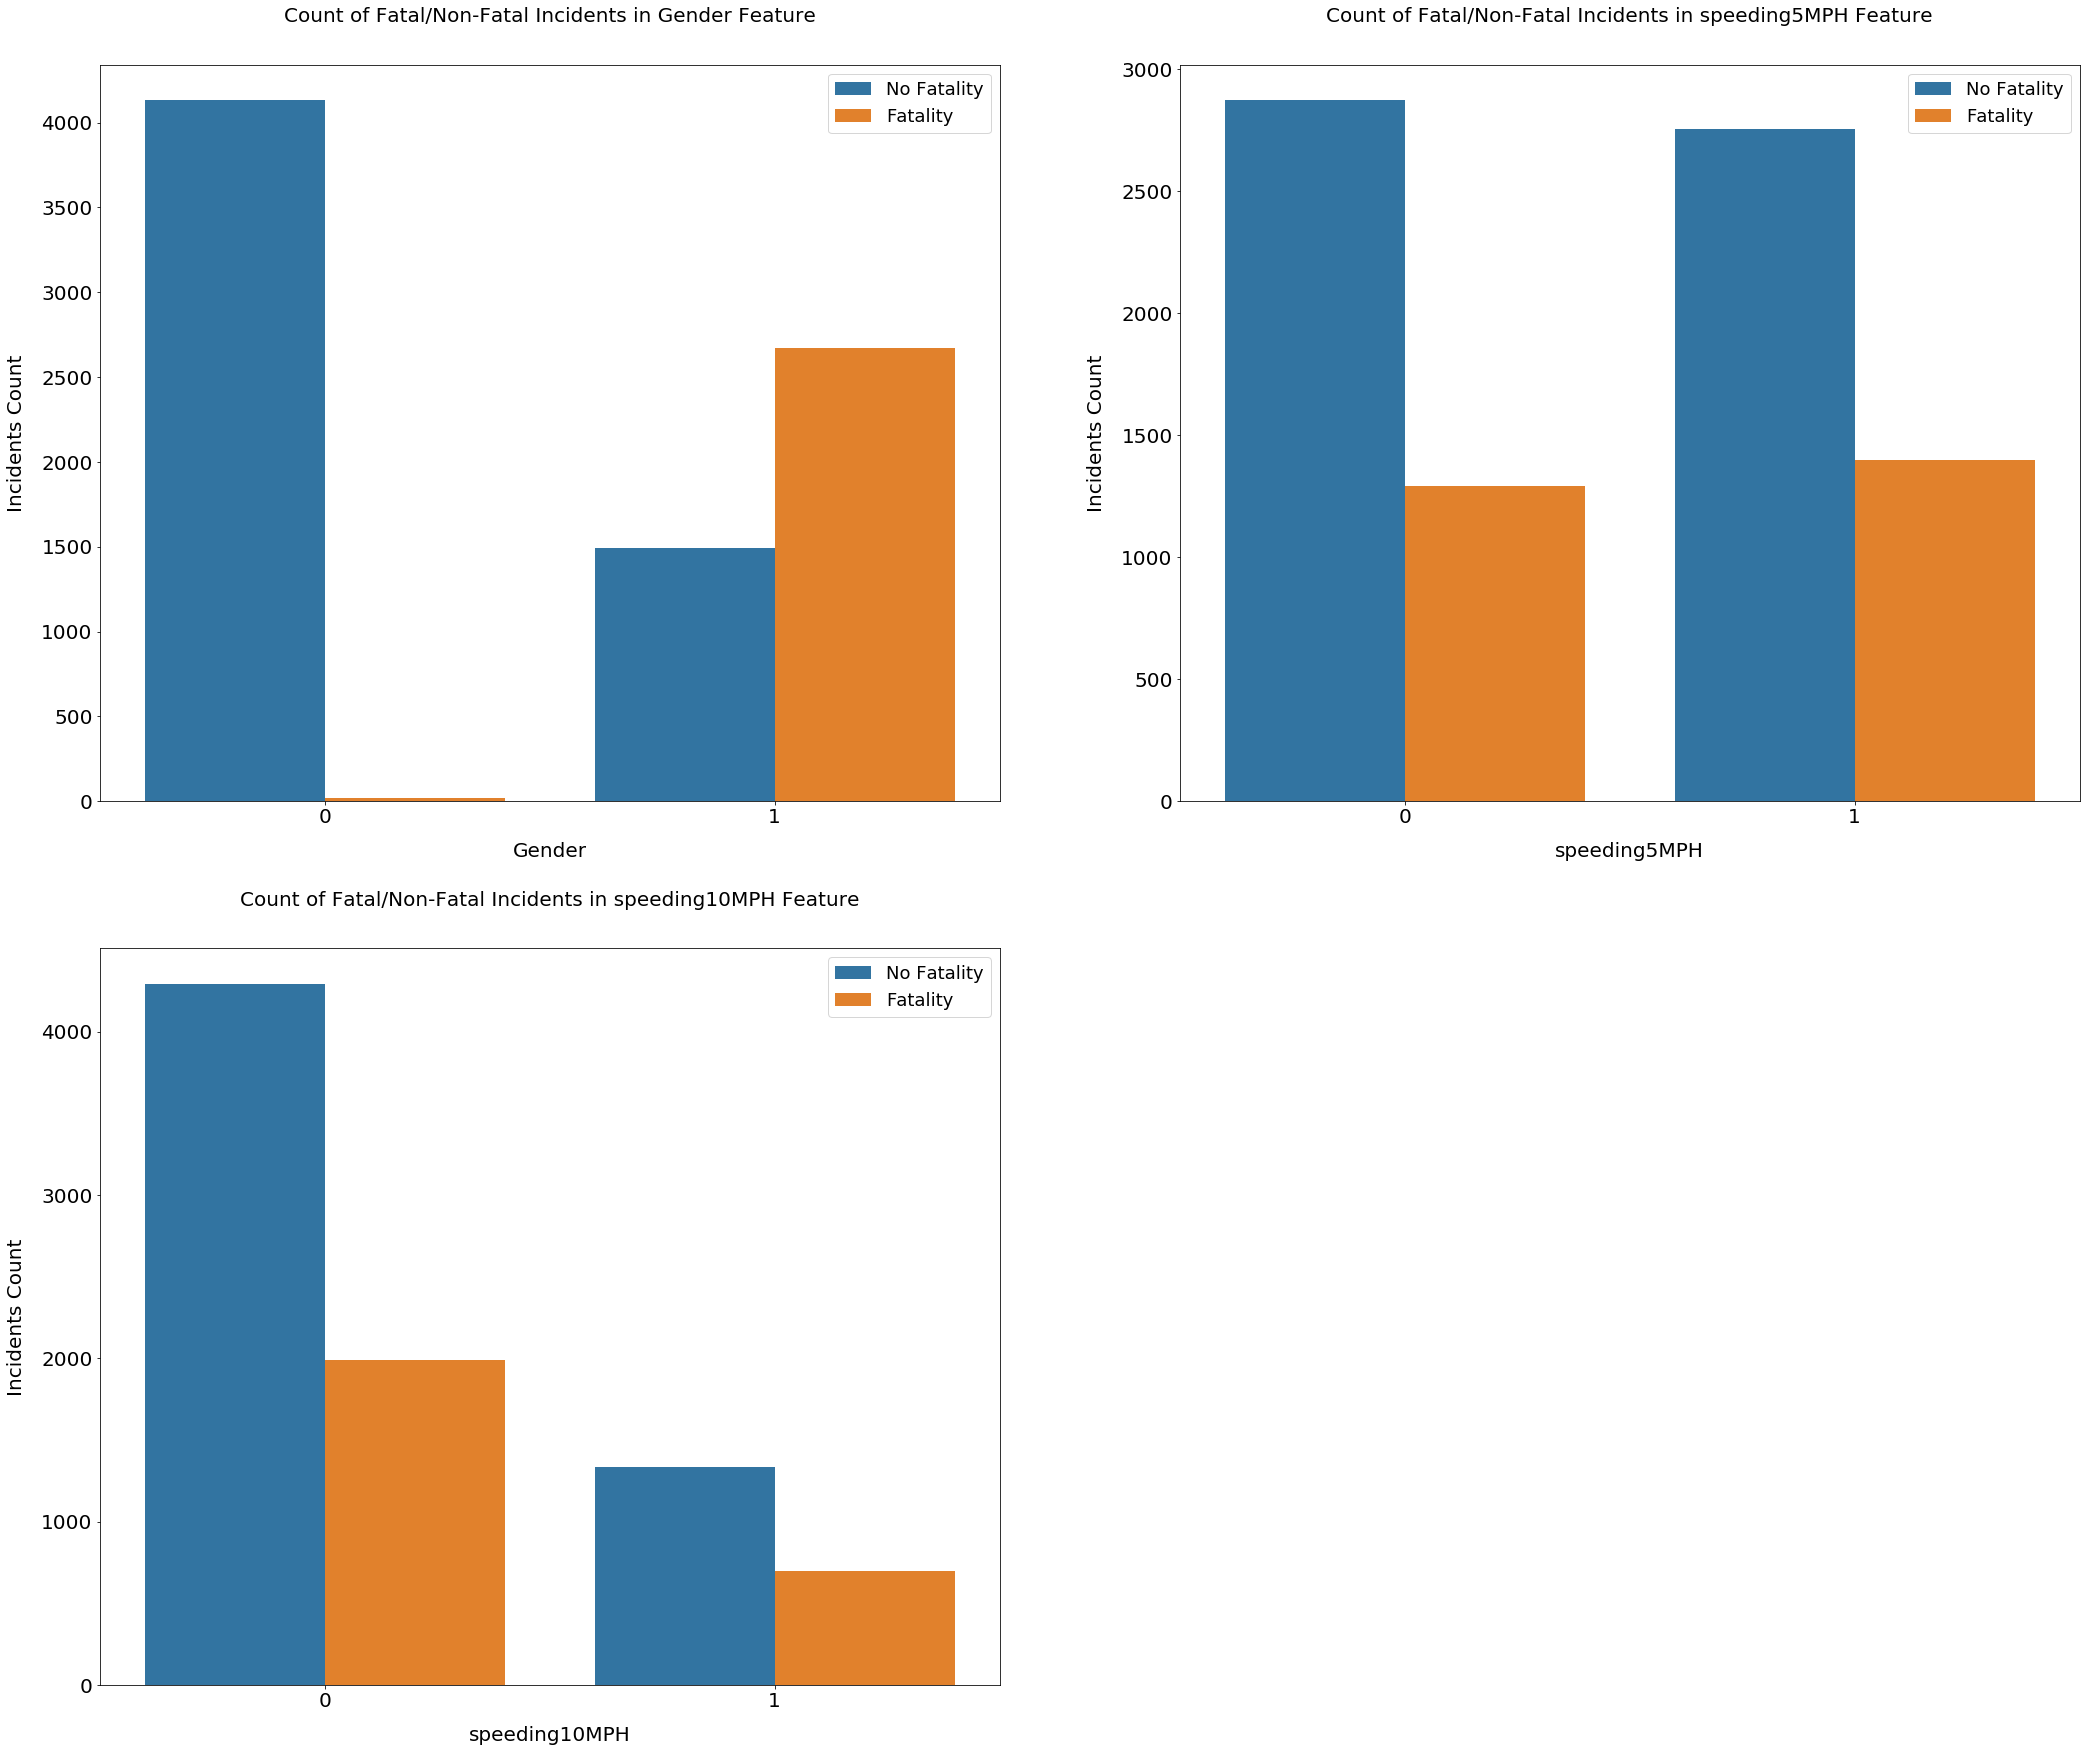

In [74]:
categorical_features = ["Gender", "speeding5MPH", "speeding10MPH"]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(categorical_features, 1):    
    plt.subplot(2, 2, i)
    sb.countplot(x=feature, hue='Fatality', data=train_df)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Incidents Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['No Fatality', 'Fatality'], loc='upper right', prop={'size': 18})
    plt.title('Count of Fatal/Non-Fatal Incidents in {} Feature'.format(feature), size=20, y=1.05)

fig.delaxes(axs[1, 1])
plt.show()

* Gender shows a very different distribution for fatal and non-fatal incidents, which indicates that it is an important signal
* Speeding 10MPH and speeding 5MPH is relatively similar in distribution

## Continuous Features

In [85]:
train_df[train_df['Fatality'] == 1]

,Age,Gender,BAC,speeding5MPH,speeding10MPH,Fatality
1,38,1,0.034,0,0,1
5,90,1,0.035,0,0,1
9,51,1,0.066,1,1,1
10,29,1,0.039,1,0,1
12,84,1,0.019,1,0,1
15,71,1,0.023,0,0,1
16,82,1,0.042,0,0,1
20,79,1,0.058,1,0,1
26,62,1,0.026,0,0,1
27,45,1,0.000,0,0,1


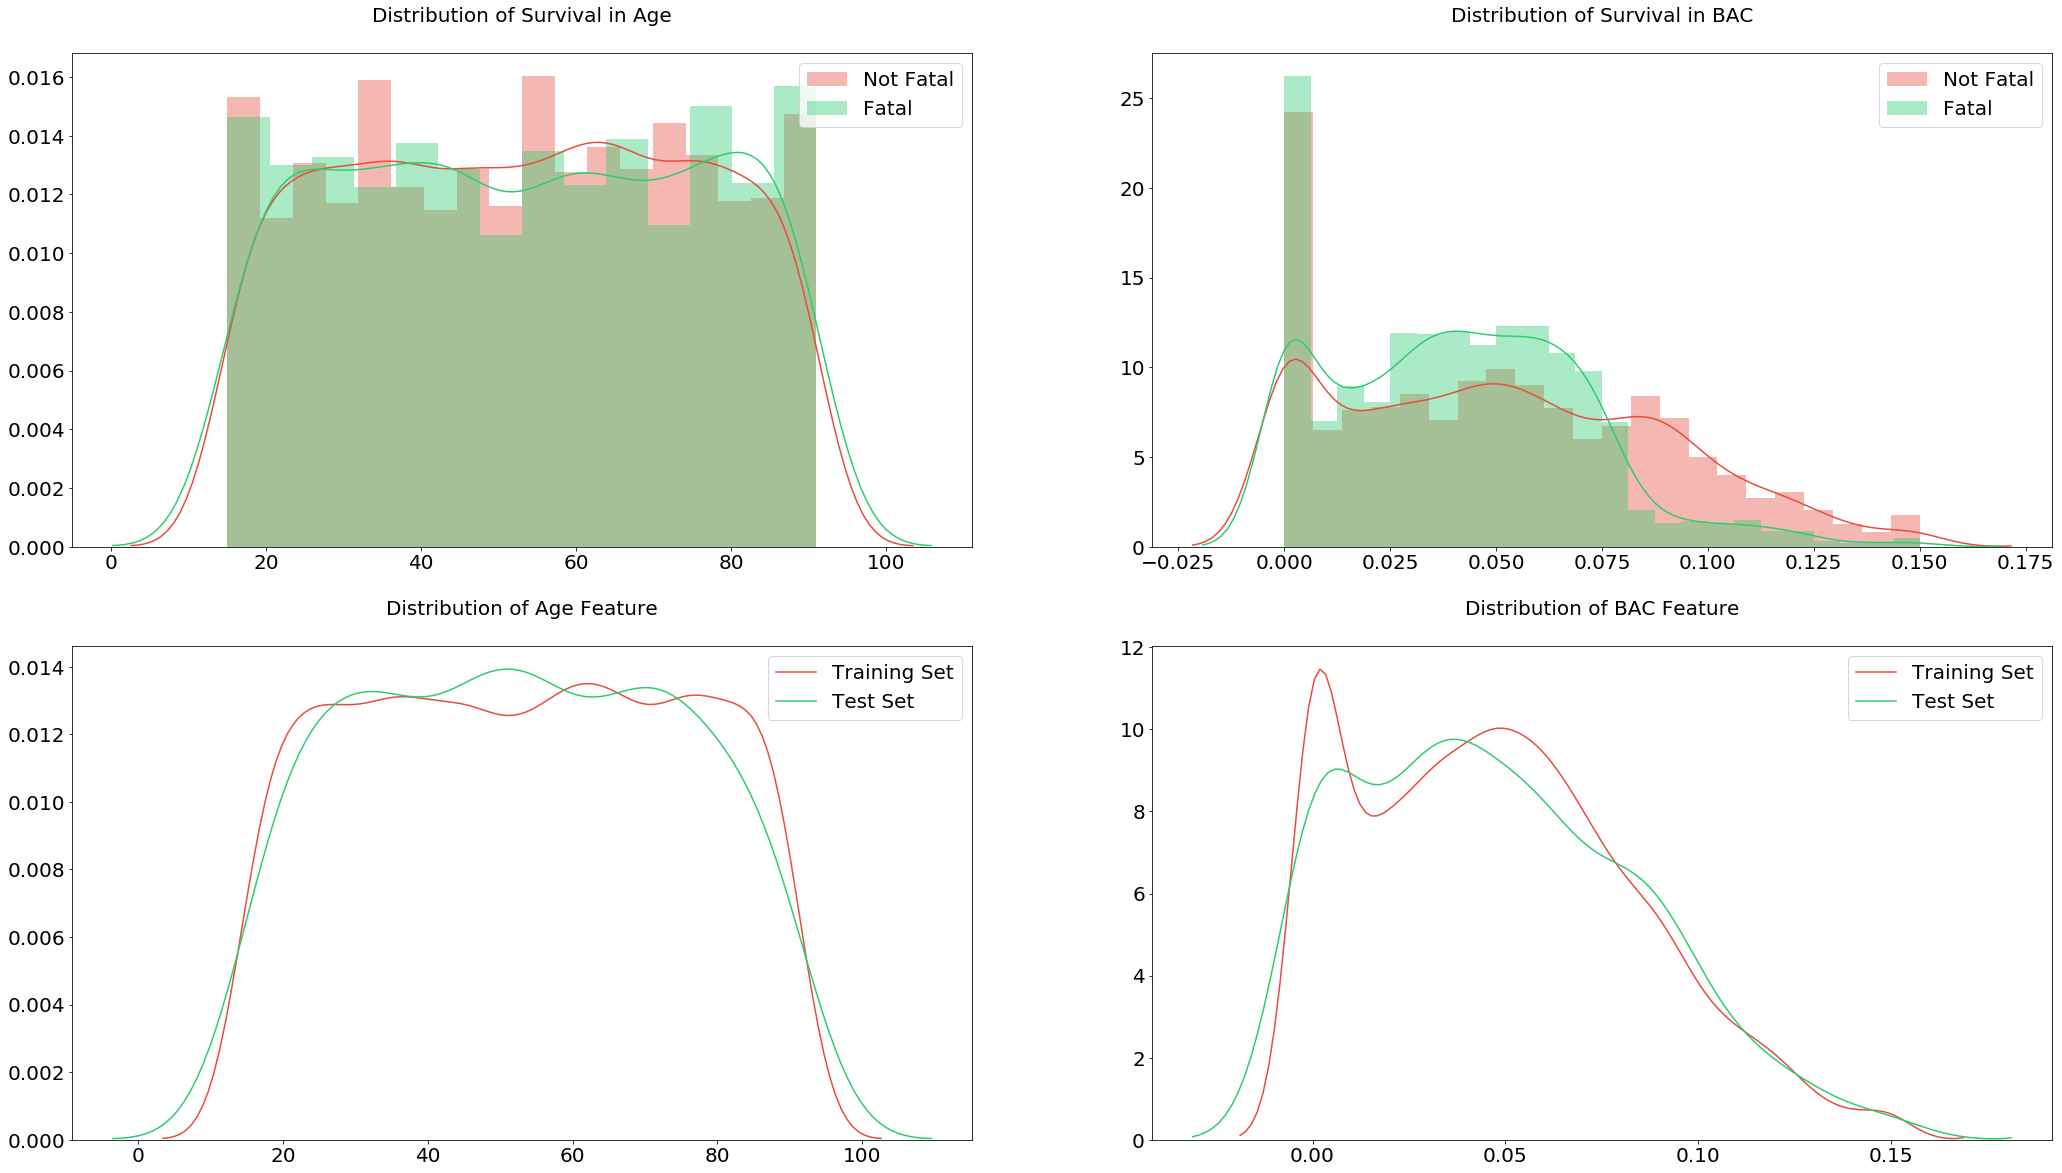

In [88]:
continuous_features = ['Age', 'BAC']
fatal = train_df['Fatality'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(continuous_features):    
    # Distribution of fatalities in feature
    sb.distplot(train_df[~fatal][feature], label='Not Fatal', hist=True, color='#e74c3c', ax=axs[0][i])
    sb.distplot(train_df[fatal][feature], label='Fatal', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of fatalities in dataset
    sb.distplot(train_df[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sb.distplot(test_df[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('BAC'), size=20, y=1.05)
        
plt.show()

* BAC shows that there is a significantly lower fatal incidents when the BAC was high
* BAC distributions for fatal and non-fatal incidents are very different, especially in the relatively frequency in higher values
* We can see that the distribution of age and BAC is similar for both train and test sets
    * Age resembles a square wave like distribution
    * BAC is skewed both skewed right

## Correlation Between Features

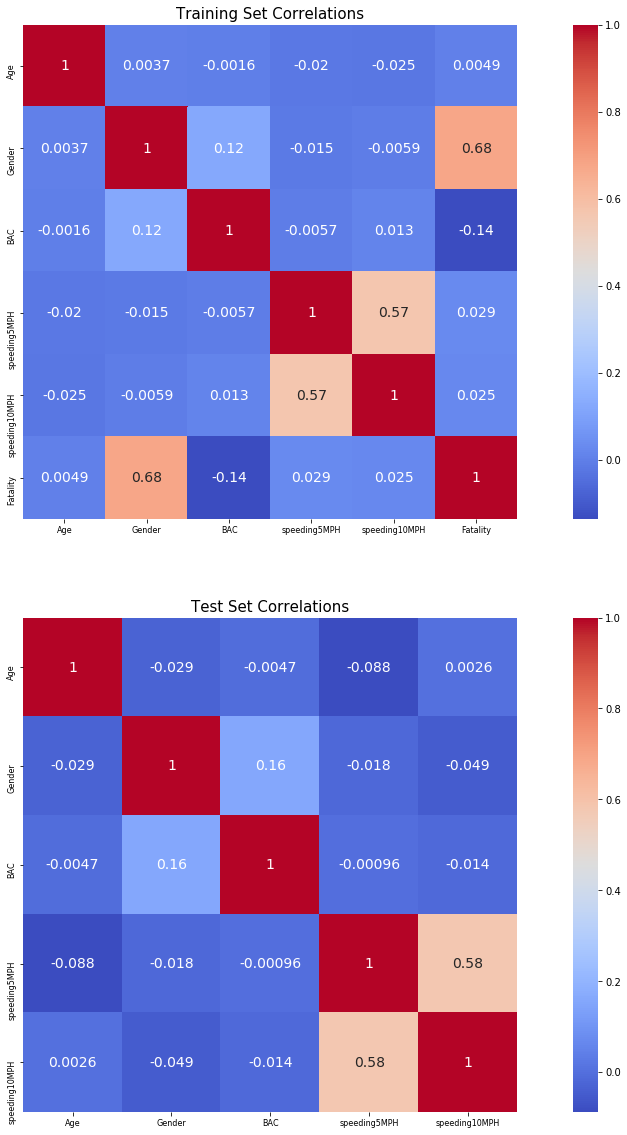

In [76]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sb.heatmap(train_df.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sb.heatmap(test_df.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

* The correlation heatmap shows that Gender and BAC have the highest correlation to fatal incidents
* BAC and Age have low correlation with each other
* Correlation for BAC and Age with fatality is slightly different between the train and test sets

In [7]:
x_columns = ["Age", "Male", "Female", "BAC", "speeding5MPH", "speeding10MPH"]
y_columns = ["Fatality"]
train_X = train_df[x_columns]
train_Y = train_df["Fatality"]
test_X = test_df[x_columns]

## Training
* Since we only have 8300 examples, it doesn't make sense to use deep learning. 
* Also since this is a classfication problem, we'll use Random Forest, that shown to perform relatively well in small data
* K-fold validation will be used to evaluate the model
* From having analyzed the distribution and correlation of different categories, BAC and gender are the best choices. Other categories have distributions similar to fatal vs. not-fatal, and/or have low correlation with fatal/not-fatal incidents

In [83]:
clf = RandomForestClassifier(n_estimators=10)
score = cross_val_score(clf, train_X, train_Y, cv=5) # Classification using all 5 categories
print(score)
print(np.mean(score))

[0.84855769 0.85697115 0.86117788 0.84975962 0.84726398]
0.8527460653823026


In [97]:
clf = RandomForestClassifier(n_estimators=10)
score = cross_val_score(clf, train_X[["Gender", "BAC"]], train_Y, cv=5) # Classification using the chosen 2 features
print(score)
print(np.mean(score))

[0.89362981 0.890625   0.90204327 0.88701923 0.88755262]
0.8921739846893937


* With initial parameters, and with all 5 categories we can see a mean score of 85% accuracy
* By using the 2 chosen categories, Gender and BAC, we can achieve a 89.2% accuracy, which is a 4.2% increase
* Hyperparameter tuning can be done with sklearn's GridsearchCV, which performs an exhaustive search using different parameters
    * We will use grid search to change the parameters, such as max_depth, max_features, minimum samples per split, bootstrap and criterion

In [95]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [100]:
param_grid = {"n_estimators": [10, 50, 100, 150],
              "max_depth": [3, None],
              "max_features": [1, 2],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 150], 'max_depth': [3, None], 'max_features': [1, 2], 'min_samples_split': [2, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.894 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 3, 'n_estimators': 50}

Model with rank: 2
Mean validation score: 0.894 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.894 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 150}

Model with rank: 2
Mean validation score: 0.894 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 3, 'n_estimators': 150}

Model with rank: 2
Mean validation score: 0.894 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 10, 'n_estimators': 100}

Model with rank: 2
Mean v

## Final model selection
* The grid search has found the best accuracy of 89.4%, which is a 0.2% from initial hyperparamters.
* It also found many configurations that have acheived this 89.4% accuracy
* Choosing the simplest model, one appropriate configuration would be:
    * Bootstrap: True
    * criterion: gini
    * max_depth: 3
    * max_features: 2
    * min_samples_split: 10
    * n_estimators: 100

In [104]:
clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=3,
                             max_features=2, min_samples_split=10, n_estimators=100)
score = cross_val_score(clf, train_X, train_Y, cv=5)
print(score)
print(np.mean(score))

[0.89362981 0.89002404 0.90444712 0.88822115 0.89176188]
0.8936167983024191
